In [1]:
import pandas as pd
import numpy as np
import math
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error,  auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from typing import List, Dict
from random import choices
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_wine
from sklearn.impute import KNNImputer
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
warnings.filterwarnings('ignore')

---

# Import the data 💽

In [2]:
df = pd.read_csv("./train.csv")
df.shape #There are 60K examples in the data set and 24 features

(60000, 24)

In [3]:
df_label = df.iloc[:, -1] #get the labels
X_train, X_validation, y_train, y_validation = train_test_split(df, df_label, train_size=0.8, random_state=42, shuffle=True)
# Split the data into training and validation sets
# X_train: Training features
# X_validation: Validation features
# y_train: Training labels
# y_validation: Validation labels

---

# Explore the data 🔬

In [4]:
X_train.drop_duplicates(inplace=True) #remove for duplicate rows by Unique Identifier "sha256".
X_train.shape #There are 0 duplicated rows

(48000, 24)

In [5]:
X_train.groupby('label').size() # Counts the occurrences of each label in the X_train dataframe

label
0    23857
1    24143
dtype: int64

We can notice that the data splits even between the two labels.

In [6]:
missing_values = X_train.isnull().sum()
missing_values.sort_values(ascending=False) # Sorting the values with the most Nulls in the data

B                      3027
A                      2983
paths                  2952
has_relocations        2650
MZ                     2483
has_debug              2324
has_tls                2304
avlength               2186
printables             2178
numstrings             2161
symbols                2120
registry               2049
urls                   1878
exports                1677
C                      1636
has_resources          1564
has_signature          1554
vsize                  1546
imports                1370
sha256                    0
file_type_prob_trid       0
file_type_trid            0
size                      0
label                     0
dtype: int64

In [7]:
print("Total number of null values:", missing_values.sum())

Total number of null values: 40642


In [8]:
X_train.dtypes.sort_values(ascending=False)

sha256                  object
C                       object
file_type_trid          object
urls                   float64
B                      float64
A                      float64
file_type_prob_trid    float64
avlength               float64
printables             float64
MZ                     float64
registry               float64
paths                  float64
numstrings             float64
symbols                float64
has_tls                float64
has_signature          float64
has_resources          float64
has_relocations        float64
has_debug              float64
exports                float64
imports                float64
vsize                  float64
size                     int64
label                    int64
dtype: object

Most of the features are numerical, 'sha256', 'file_type_trid' and 'C' are strings.

---

#### Count of Unique Values for Each Feature <br>
The code below is used to calculate the count of unique values for each feature in the X_train DataFrame. This helps us understand the variability and distinctness of values in each column.

In [9]:
X_train.nunique().sort_values()

label                      2
has_tls                    2
has_resources              2
has_relocations            2
has_debug                  2
has_signature              2
C                          7
registry                  54
file_type_trid            84
paths                    150
symbols                  345
urls                     379
MZ                       506
exports                  691
file_type_prob_trid      716
imports                 1029
vsize                   2936
numstrings             12352
size                   22826
printables             28589
avlength               35937
B                      39479
A                      45017
sha256                 48000
dtype: int64

We have a few binary features, such as 'has_debug'. <br>
We can notice that 'C' is a categorical feature with 7 different values.

---

#### Split features into type groups

- *Binary*

In [10]:
binary_vars = []

for column in X_train.columns:
    unique_values = X_train[column].unique()
    if len(unique_values) <= 3 and column != 'label':
        # Check if the column has two unique values or contains null values
        if len(unique_values) == 2 or X_train[column].isnull().any():
            binary_vars.append(column)

print(binary_vars) #list of all the binay features

['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']


- *Numeric*

In [11]:
numeric_vars = []

for column in X_train.columns:
    # Check if the column is of integer type and has more than 2 unique values
    if (X_train[column].dtype == 'int64' or X_train[column].dtype == 'float64') and X_train[column].nunique() > 3:
        numeric_vars.append(column)

print(numeric_vars) #list of all the numeric features

['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B']


- *Categorial*

In [12]:
cat_vars = ['sha256', 'file_type_trid', 'C']
print(cat_vars) #list of all the categorial features

['sha256', 'file_type_trid', 'C']


---

#### Generate the descriptive statistics of the data

In [13]:
summary_stats = X_train.drop('label', axis=1).describe().T
summary_stats['median'] = X_train.median() #the median will be use later to deal with nulls

summary_stats.round(2) # Customize formatting to round values to 2 decimal places

,count,mean,std,min,25%,50%,75%,max,median
size,48000.0,1504819.22,4808623.13,324.00,107088.00,489984.00,1243566.00,3.253537e+08,489984.00
vsize,46454.0,1992192.38,22224118.69,544.00,122880.00,425984.00,1609728.00,4.278288e+09,425984.00
imports,46630.0,106.69,222.28,0.00,1.00,28.00,153.00,1.504700e+04,28.00
exports,46323.0,29.19,443.91,0.00,0.00,0.00,0.00,3.634300e+04,0.00
has_debug,45676.0,0.40,0.49,0.00,0.00,0.00,1.00,1.000000e+00,0.00
has_relocations,45350.0,0.54,0.50,0.00,0.00,1.00,1.00,1.000000e+00,1.00
has_resources,46436.0,0.86,0.35,0.00,1.00,1.00,1.00,1.000000e+00,1.00
has_signature,46446.0,0.25,0.44,0.00,0.00,0.00,1.00,1.000000e+00,0.00
has_tls,45696.0,0.23,0.42,0.00,0.00,0.00,0.00,1.000000e+00,0.00
symbols,45880.0,33.09,814.67,0.00,0.00,0.00,0.00,6.398400e+04,0.00


---

#### Exploring File Type Distribution
Before proceeding with the analysis, it is crucial to understand the distribution of file types in the dataset. This step allows us to gain insights into the prevalence of different file types and their relative frequencies.

To visualize the file type distribution, we will create a histogram showing the count of each file type. However, due to potential imbalances in the dataset and a wide range of file type counts, it is often useful to display the histogram on a logarithmic scale.

By displaying the histogram on a logarithmic scale, we can effectively visualize both the high-frequency file types and the less frequent ones. This scaling facilitates a more comprehensive understanding of the overall distribution and helps identify any skewed patterns or outliers that may exist.

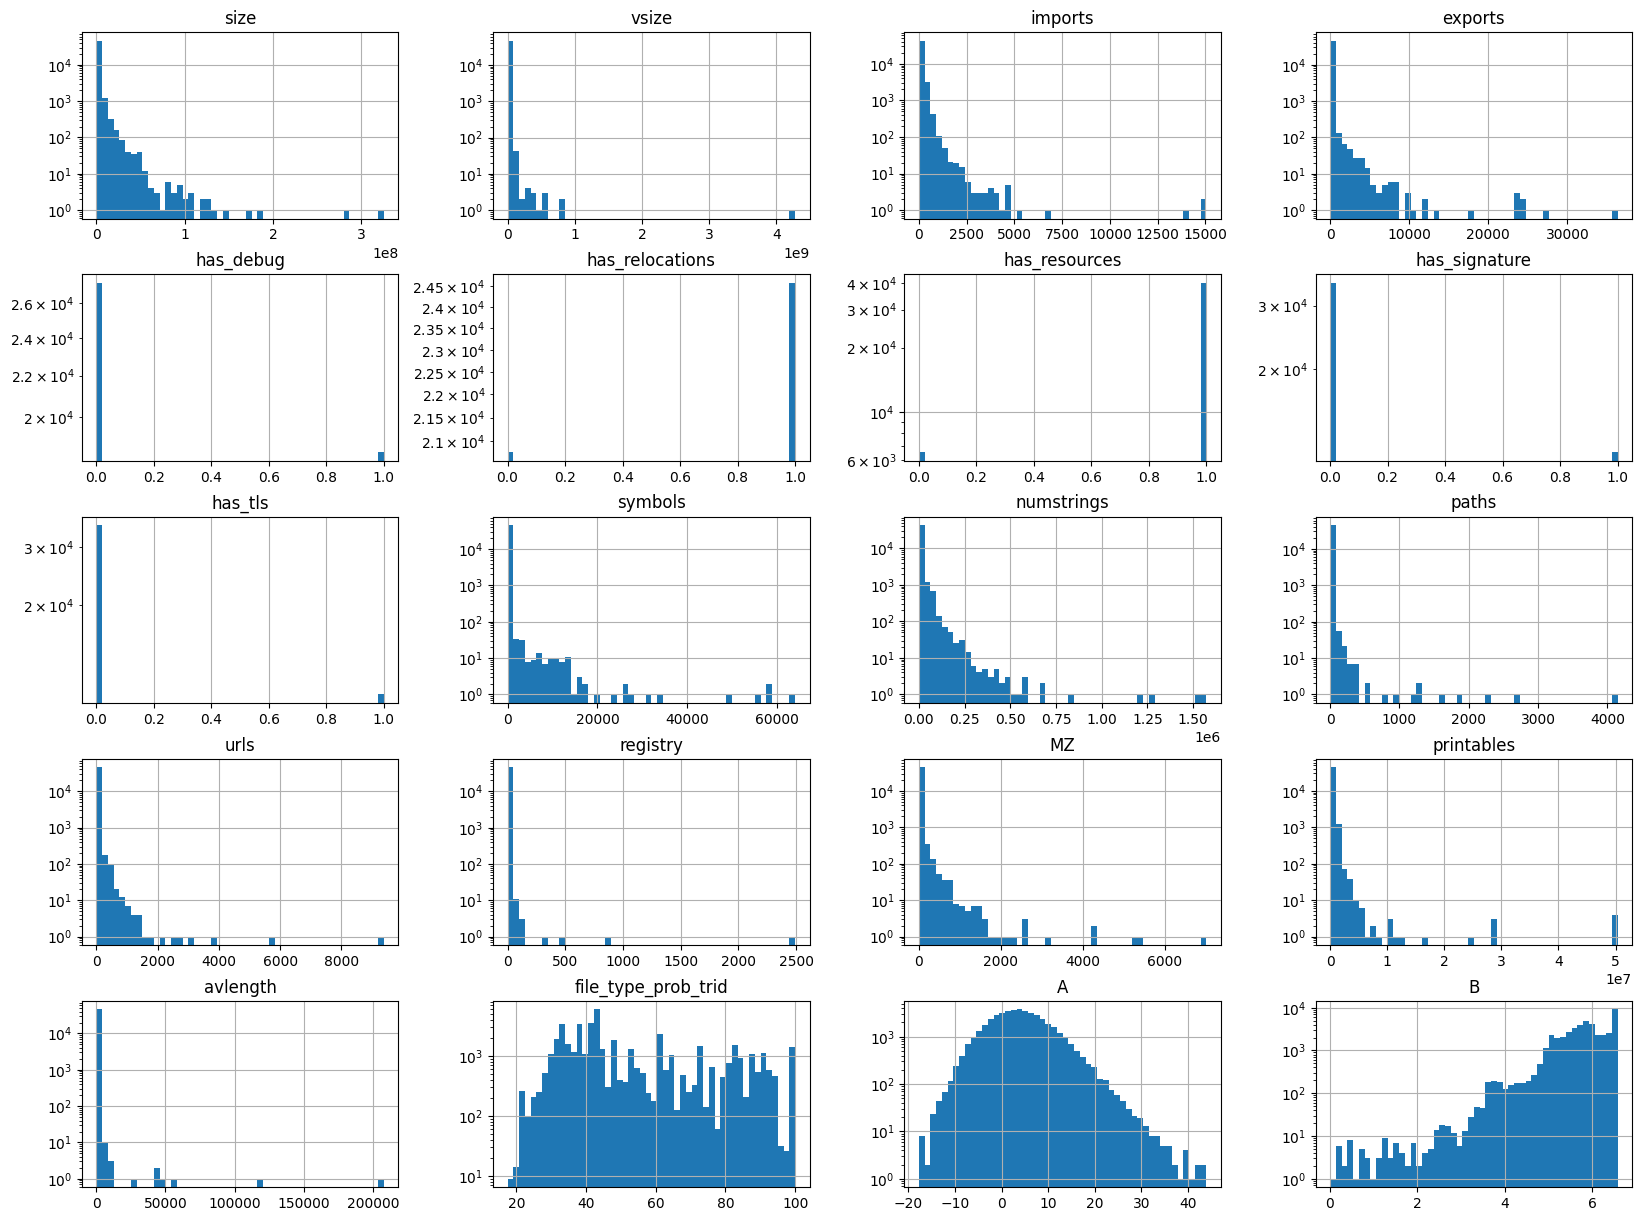

In [14]:
X_train.drop('label', axis=1).hist(bins=50, figsize=(20, 15), log=True)
plt.show()

---

#### Let us examine the distribution of each label by the features:

label 0 histogram:


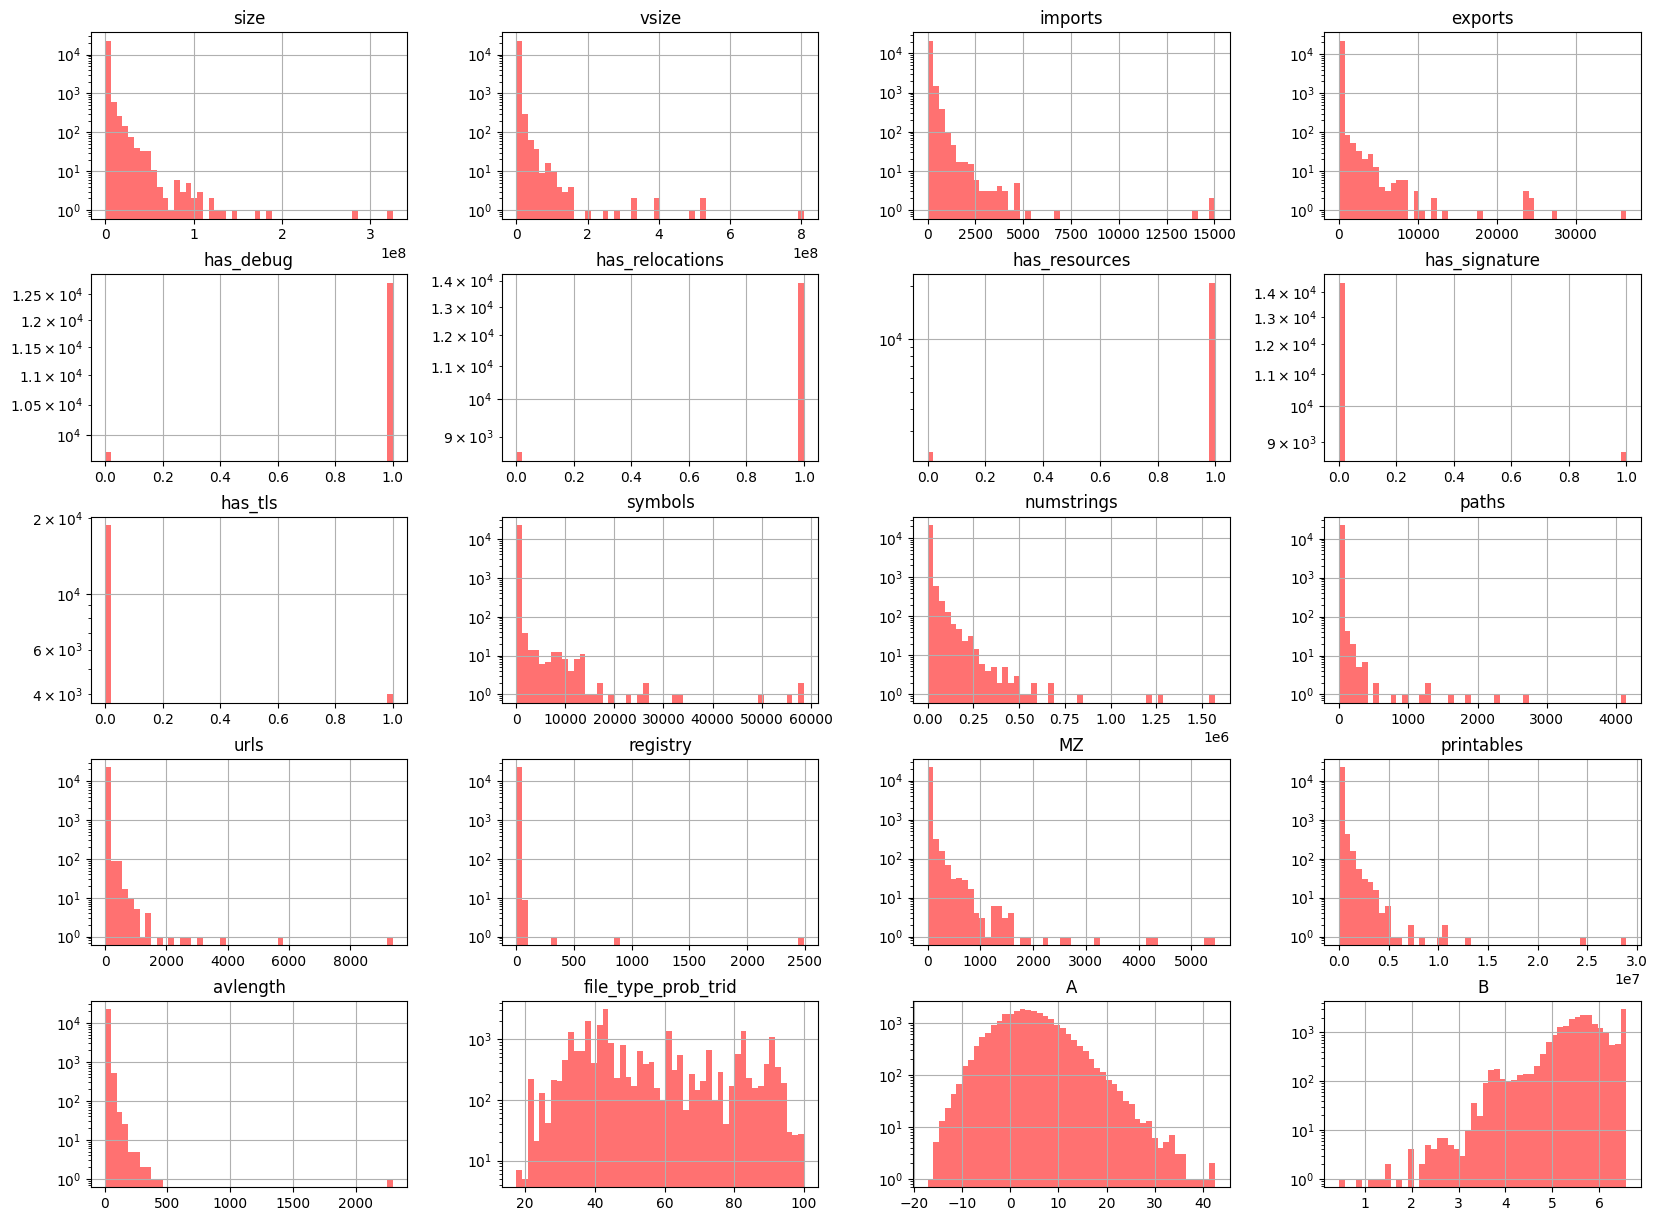

label 1 histogram:


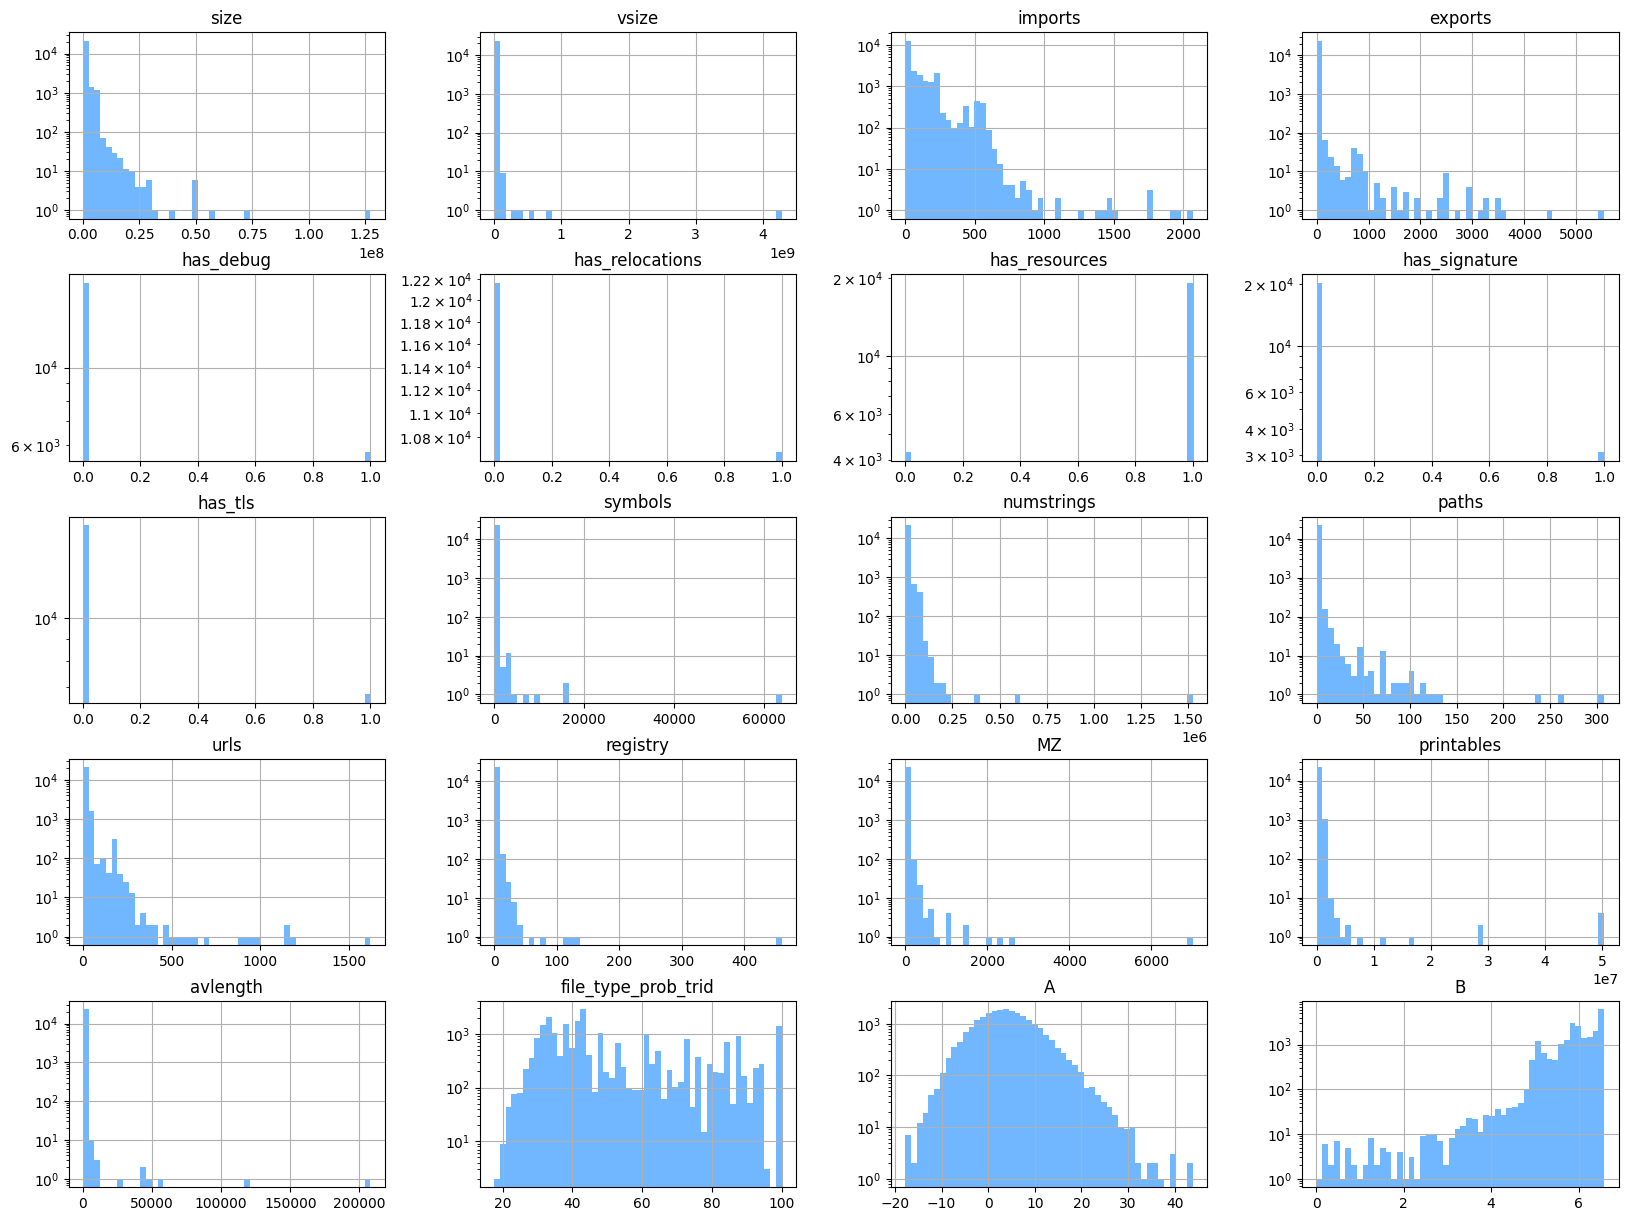

In [15]:
# Split X_train into two dataframes based on 'label' column
df_label_0 = X_train[X_train['label'] == 0]
df_label_1 = X_train[X_train['label'] == 1]

print("label 0 histogram:")
df_label_0.drop('label', axis=1).hist(bins=50, figsize=(20, 15),color='#FF7171', log=True)
plt.show()

print("label 1 histogram:")
df_label_1.drop('label', axis=1).hist(bins=50, figsize=(20, 15),color='#71B7FF', log=True)

plt.show()

By examining the histograms separately for different label values, we can observe any variations, trends, or outliers in the feature distributions that might be indicative of their predictive value. This analysis helps in identifying features that exhibit distinct distributions for different labels, which can be valuable for understanding the relationship between features and labels and making informed decisions during the model development and feature selection processes.

We can notice that there is no significant difference between those 2 histograms plots. <br>
The few different features are: 'avlength', 'vsize', 'registry' and 'exports'.

---

#### Correlation Heatmap:

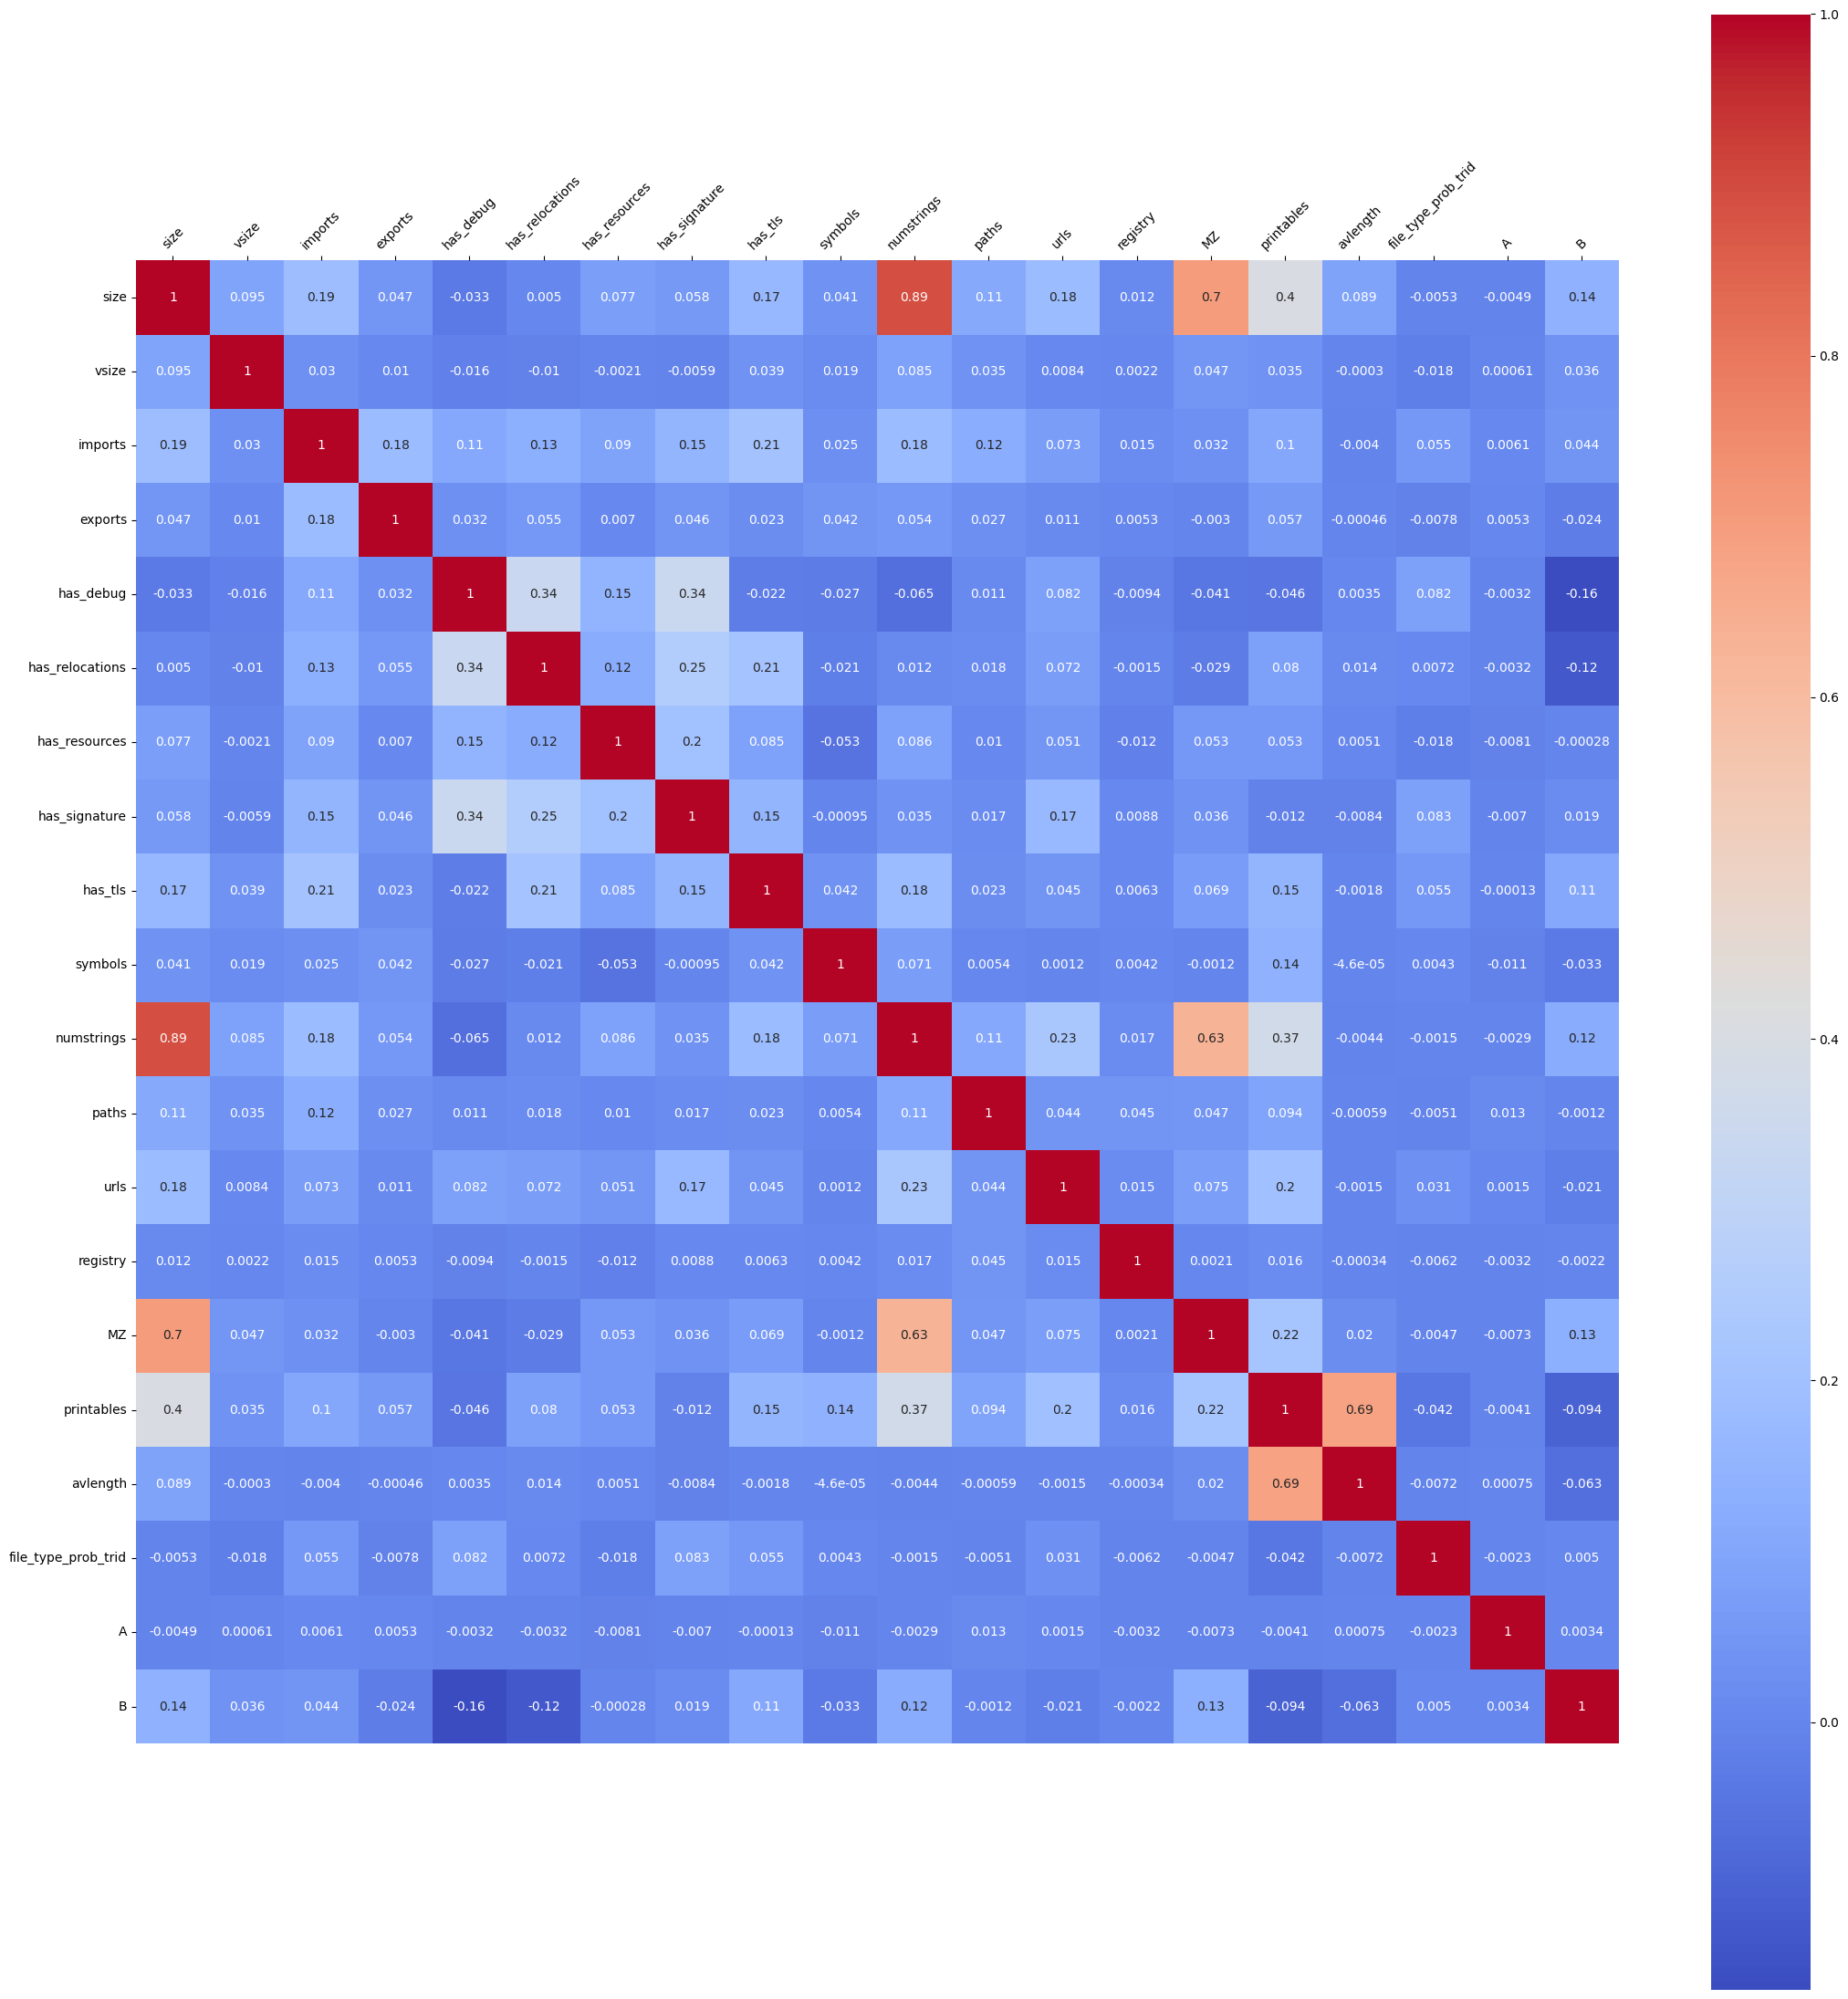

In [16]:
corr_matrix = X_train.drop('label', axis=1).corr()

# Plot the correlation matrix
plt.figure(figsize=(22, 22))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

**Identifying Highly Correlated Features**

We found strong correlations between the following feature pairs:
- 'MZ' and 'size'
- 'numstrings' and 'size'
- 'MZ' and 'numstrings'

To reduce dimensionality, we will remove two features with the highest number of missing values. This approach prioritizes removing potentially less reliable data while retaining the most informative features.

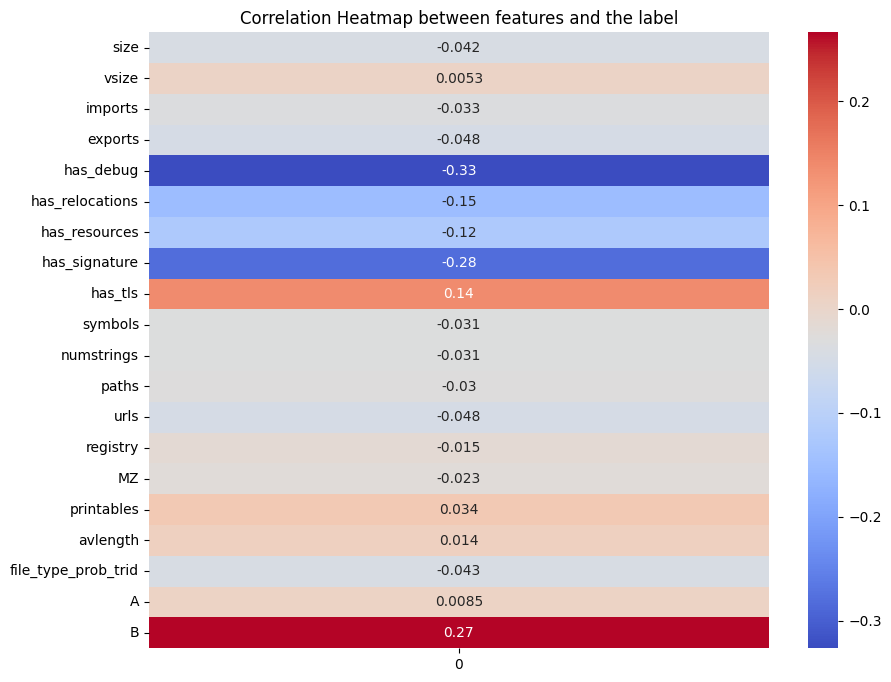

In [17]:
# Compute the correlation matrix without the 'label' feature
corr_matrix = X_train.drop('label', axis=1).corrwith(X_train['label'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.to_frame(), annot=True, cmap='coolwarm')

plt.title('Correlation Heatmap between features and the label')
plt.show()

The correlation heatmap shows the relationship between each variable and the 'label' feature. It helps identify the strength and direction of association, assisting in feature selection and understanding the predictive power of each variable.

---

#### Better look on the binary features:

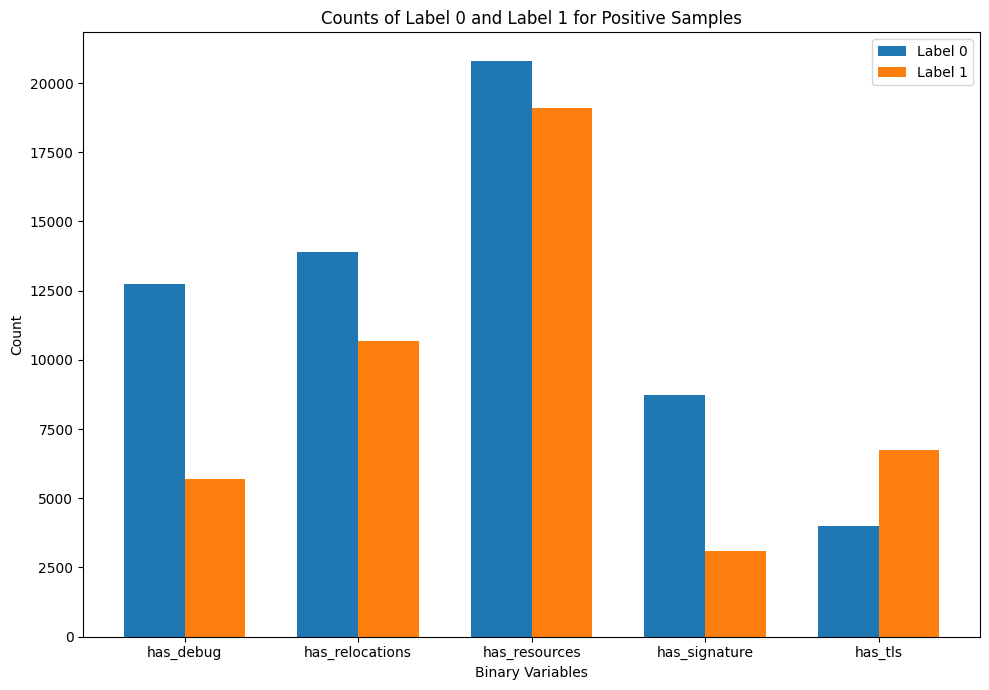

In [18]:
counts_0 = []
counts_1 = []

for var in binary_vars:
    positive_samples = X_train[X_train[var] == 1]
    counts_0.append(len(positive_samples[positive_samples['label'] == 0]))
    counts_1.append(len(positive_samples[positive_samples['label'] == 1]))

x = range(len(binary_vars))
width = 0.35

plt.figure(figsize=(10, 7))

plt.bar([i - width/2 for i in x], counts_0, width, label='Label 0')
plt.bar([i + width/2 for i in x], counts_1, width, label='Label 1')

plt.xlabel('Binary Variables')
plt.ylabel('Count')
plt.title('Counts of Label 0 and Label 1 for Positive Samples')
plt.xticks(x, binary_vars, rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

We can observe the following relationships between variables and the label:

- **Debugging**: Files that have been debugged are more likely to be non-malicious.

- **Relocations and Signature**: The presence of relocations and a signature indicates a higher likelihood of non-malicious files.

- **TLS** (Thread Local Storage): The presence of TLS suggests a higher likelihood of malicious files.

- **Resources**: The presence of resources shows an approximately equal likelihood for both labels, with about 50% chance for each.


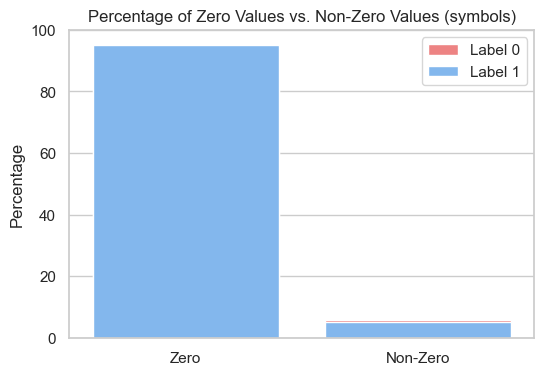

Percentage of zero values in symbols for Label 0: 94.24%
Percentage of non-zero values in symbols for Label 0: 5.76%
Percentage of zero values in symbols for Label 1: 94.99%
Percentage of non-zero values in symbols for Label 1: 5.01%


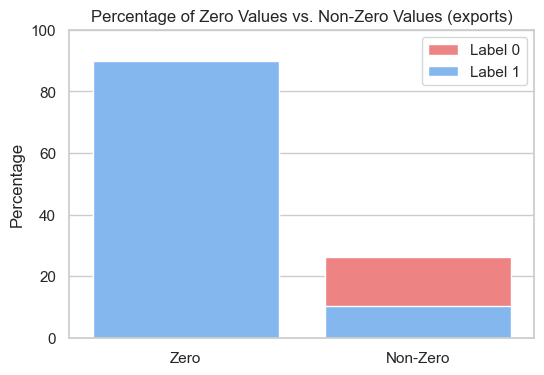

Percentage of zero values in exports for Label 0: 73.80%
Percentage of non-zero values in exports for Label 0: 26.20%
Percentage of zero values in exports for Label 1: 89.71%
Percentage of non-zero values in exports for Label 1: 10.29%


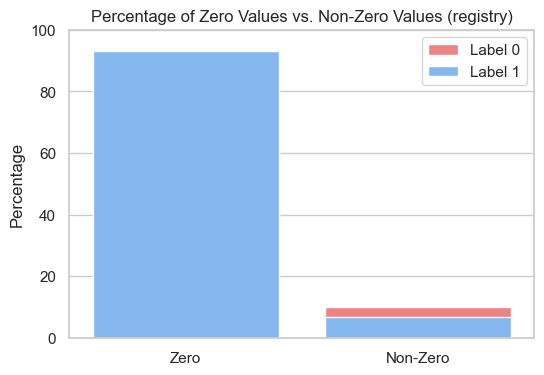

Percentage of zero values in registry for Label 0: 89.86%
Percentage of non-zero values in registry for Label 0: 10.14%
Percentage of zero values in registry for Label 1: 93.09%
Percentage of non-zero values in registry for Label 1: 6.91%


In [19]:
variables_of_interest = ['symbols', 'exports', 'registry']

# Define custom colors
colors = ['#FF7171', '#71B7FF']

for var in variables_of_interest:
    # Calculate the percentage of zero values for label 0
    zero_count_label0 = (X_train[X_train['label'] == 0][var] == 0).sum()
    non_zero_count_label0 = len(X_train[X_train['label'] == 0][var]) - zero_count_label0
    zero_percentage_label0 = (zero_count_label0 / len(X_train[X_train['label'] == 0][var])) * 100
    non_zero_percentage_label0 = 100 - zero_percentage_label0

    # Calculate the percentage of zero values for label 1
    zero_count_label1 = (X_train[X_train['label'] == 1][var] == 0).sum()
    non_zero_count_label1 = len(X_train[X_train['label'] == 1][var]) - zero_count_label1
    zero_percentage_label1 = (zero_count_label1 / len(X_train[X_train['label'] == 1][var])) * 100
    non_zero_percentage_label1 = 100 - zero_percentage_label1

    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 4))

    sns.barplot(x=['Zero', 'Non-Zero'], y=[zero_percentage_label0, non_zero_percentage_label0],
                color=colors[0], label='Label 0')
    sns.barplot(x=['Zero', 'Non-Zero'], y=[zero_percentage_label1, non_zero_percentage_label1],
                color=colors[1], label='Label 1')

    plt.title(f'Percentage of Zero Values vs. Non-Zero Values ({var})')
    plt.ylabel('Percentage')
    plt.ylim(0, 100)
    plt.legend()
    plt.show()

    # Print the percentage of zero values for each label
    print(f"Percentage of zero values in {var} for Label 0: {zero_percentage_label0:.2f}%")
    print(f"Percentage of non-zero values in {var} for Label 0: {non_zero_percentage_label0:.2f}%")
    print(f"Percentage of zero values in {var} for Label 1: {zero_percentage_label1:.2f}%")
    print(f"Percentage of non-zero values in {var} for Label 1: {non_zero_percentage_label1:.2f}%")


Based on our analysis, it is evident that the variables 'symbols', 'exports', and 'registry' are predominantly composed of 0 values.

When 'registry' and 'symbols' have a significant number of zeros for both labels, 'exports' shows a slight connection between labels and the value of the feature:<br>
Percentage of zero values in exports for Label 0: 73.71% <br>
Percentage of non-zero values in exports for Label 0: 26.29% <br>
Percentage of zero values in exports for Label 1: 89.78% <br>
Percentage of non-zero values in exports for Label 1: 10.22% <br>

Since in 'registry' and 'symbols' the percentage of zeros is high in both labels we decided to drop them.

Given the high proportion of zeros in 'registry' and 'symbols' for both labels, it is justified to drop these variables from further analysis. This decision is based on the understanding that variables with limited variability, such as those dominated by zeros, may not provide significant insights for the analysis. By focusing on variables that exhibit greater variability, we can obtain more meaningful and informative results from the dataset

Additionally, the prevalence of 0 values in binary variables suggests a specific pattern that warrants further exploration through visualization. This exploration can provide additional insights into the dataset and help us understand the characteristics of these variables.

---

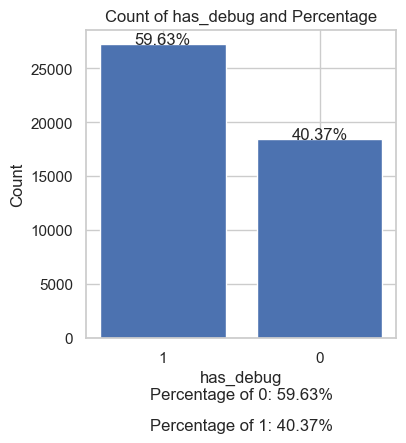

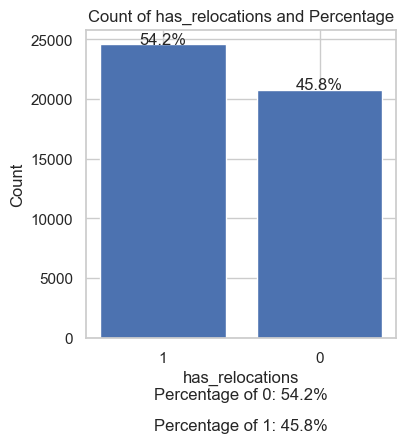

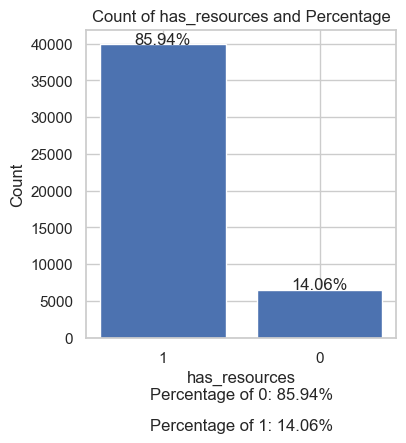

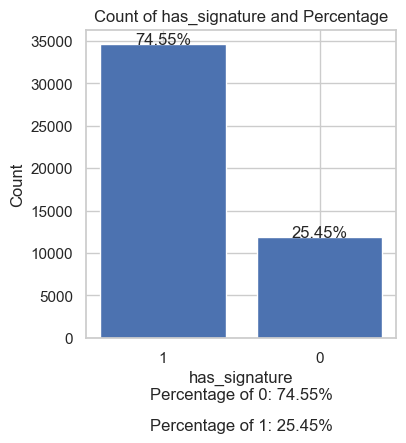

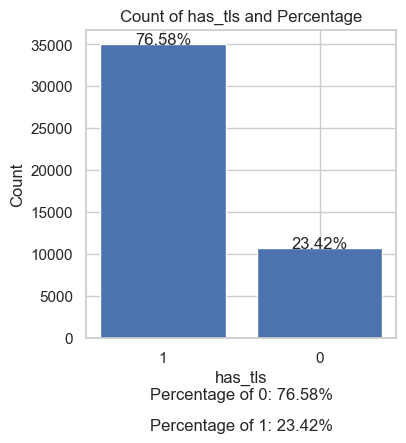

In [20]:
def visualize_binary_variables(dataframe, binary_vars):
    #creates bar plots to visualize the counts and percentages of binary variables in a given dataframe.
    for var in binary_vars:
        counts = dataframe[var].value_counts()
        total_count = counts.sum()
        percentages = counts / total_count * 100

        plt.figure(figsize=(4, 4))

        plt.bar(['1', '0'], counts.values)
        plt.xlabel(var)
        plt.ylabel('Count')
        plt.title(f'Count of {var} and Percentage')

        for i, val in enumerate(counts.values):
            plt.text(i, val + 10, f'{round(percentages.values[i], 2)}%', ha='center')

        plt.text(0.5, -0.2, f'Percentage of 0: {round(percentages.values[0], 2)}%', ha='center', transform=plt.gca().transAxes)
        plt.text(0.5, -0.3, f'Percentage of 1: {round(percentages.values[1], 2)}%', ha='center', transform=plt.gca().transAxes)

        plt.show()

visualize_binary_variables(X_train, binary_vars)

To preserve the available data, we made the decision to handle null values by replacing them with the majority value for each binary feature. This approach allows us to retain a significant portion of the original data while minimizing the impact of missing values. It will be done later in the pre-processing part.

---

# Data Pre-processing 🛠️

### Categorial features:

- **C**:<br>
As said before the feature 'C' is categorial with 7 distinct values.<br> Let's examine the distribution of these values in relation to our label:

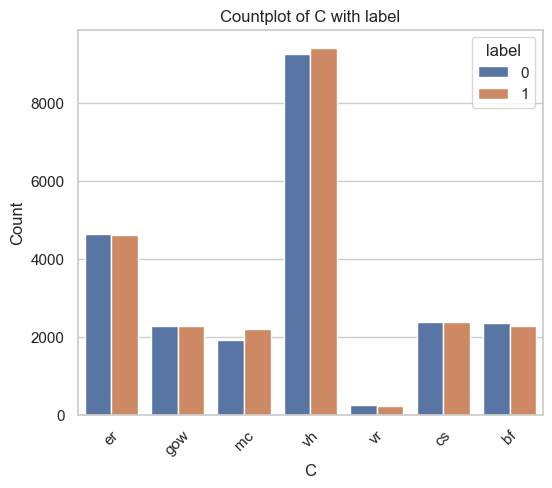

In [21]:
plt.figure(figsize=(6, 5))
use_type = sns.countplot(x='C', hue='label', data=X_train)
plt.xticks(rotation=45)
plt.title('Countplot of C with label')
plt.xlabel('C')
plt.ylabel('Count')
plt.show()

The variable 'C' does not significantly influence the decision when the data is evenly split between the two labels (50-50).<br> It may be advisable to exclude 'C' from further analysis or modeling as it lacks meaningful discriminatory information for distinguishing between the labels.

---

- **file_type_trid**: <br>
After analyzing the dataset, it was observed that the variable "file_type_trid" represents different types of files. To facilitate the analysis and modeling process, the file types were categorized into families based on the first three letters of each file type. This categorization allowed us to identify common patterns and group files that belong to the same family together.

In [22]:
# Count the number of unique file types
num_file_types = len(X_train['file_type_trid'].unique())
print(f"Number of different file types: {num_file_types}")

Number of different file types: 84


We decided to split the files into families by their first 3 letters:

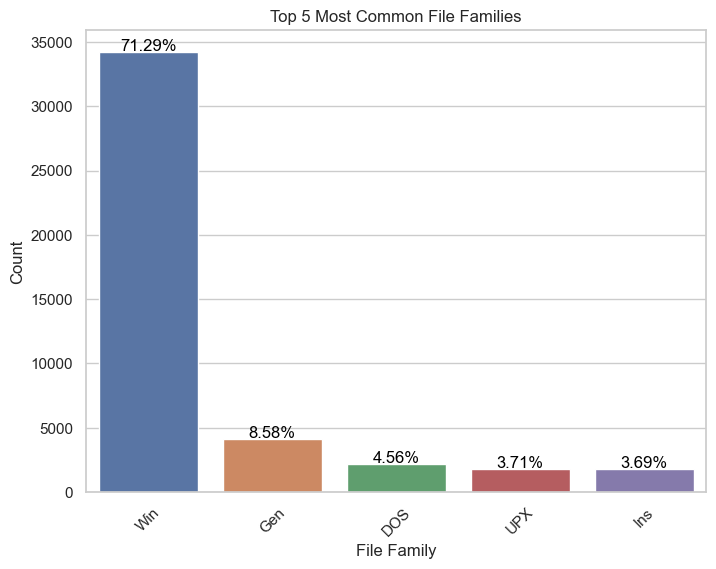

In [23]:
X_train['file_family'] = X_train['file_type_trid'].str[:3] # Extract the family name from the "file_type_trid" variable

file_family_counts = X_train['file_family'].value_counts() # Count the occurrences of each file family

top_5_file_families = file_family_counts.head(5) # Select the top 5 most common file families

file_family_percentages = (file_family_counts / len(X_train)) * 100 # Calculate the percentages of each file family

plt.figure(figsize=(8, 6))
sns.barplot(x=top_5_file_families.index, y=top_5_file_families.values)
plt.xlabel('File Family')
plt.ylabel('Count')
plt.title('Top 5 Most Common File Families')
plt.xticks(rotation=45)

for i, count in enumerate(top_5_file_families):
    percentage = file_family_percentages[top_5_file_families.index[i]]
    plt.text(i, count + 100, f'{percentage:.2f}%', ha='center', color='black')

plt.show()

To represent these file families as features in our machine learning models, we transformed the categorical variable into multiple binary variables. The top 5 most common file families were selected, and a binary variable was created for each family. Additionally, we created a binary variable to represent all other file families.

In [24]:
# Get the top 5 most common file families
top_5_file_families = file_family_counts.head(5).index.tolist()

# Define the threshold for categorizing as "other"
threshold = 5

# Create binary variables for the most frequent file families
for file_family in top_5_file_families:
    X_train[file_family] = (X_train['file_family'] == file_family).astype(int)

# Create the "other" binary variable
X_train['other'] = (X_train['file_family'].isin(top_5_file_families) == False).astype(int)

# Remove the original "file_family" column
X_train.drop('file_family', axis=1, inplace=True)

In [25]:
X_train.columns

Index(['sha256', 'size', 'vsize', 'imports', 'exports', 'has_debug',
       'has_relocations', 'has_resources', 'has_signature', 'has_tls',
       'symbols', 'numstrings', 'paths', 'urls', 'registry', 'MZ',
       'printables', 'avlength', 'file_type_trid', 'file_type_prob_trid', 'A',
       'B', 'C', 'label', 'Win', 'Gen', 'DOS', 'UPX', 'Ins', 'other'],
      dtype='object')

After few tries, we decided to drop those features since it caused overfit in our models.

In [26]:
X_train.drop(['Win', 'Gen', 'DOS', 'UPX', 'Ins', 'other'], axis=1, inplace=True)

We will drop the features: <br>

*file_type_trid* - the models can handle only numeric values. <br>
*file_type_prob_trid* - without 'file_type_trid' it probably will be meaningless.

---

- **'sha256'** - since its a unique indentifier for each file it will be dropped.

------

### Drop features manually:

In [27]:
def drop_features(df):
    
    # Remove categorical features from the data 
    df = df.drop(['file_type_trid','sha256', 'C'], axis=1)
    
    # Remove 'file_type_prob_trid' since it's meaningless without 'file_type_trid'
    df = df.drop(['file_type_prob_trid'], axis=1)
    
    # Remove features with high correlation and more null values.
    df = df.drop(['numstrings', 'MZ'], axis=1)

    # Remove the columns 'symbols' and 'registry' from the data since these variables have an overwhelming majority of zeros
    df = df.drop(['symbols', 'registry'], axis=1)
    
    # Remove 'printables' since it has a strong correlation with 'avlength' but higher number of null values.
    # 'avlength' will play a significant role in the RF model.
    df = df.drop('printables', axis=1)
    
    # Remove 'A' from the data since it has no input in the Feature importance of RF and XGboost models
    df = df.drop('A', axis=1)

    return df

In [28]:
X_train = drop_features(X_train)
X_validation = drop_features(X_validation)
X_train.head()

,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,paths,urls,avlength,B,label
48572,59904,73728.0,125.0,3.0,1.0,1.0,NaN,0.0,0.0,0.0,0.0,16.334773,5.555723,0
38696,211850,192512.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,8.771429,5.912180,1
13611,1361584,1368064.0,43.0,0.0,1.0,1.0,1.0,1.0,NaN,2.0,20.0,14.194139,5.824356,0
35213,282866,315392.0,37.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,17.978495,5.682473,0
31766,401032,86016.0,8.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,9.0,8.458374,6.307346,1


---

### Null Values:

In [29]:
def replace_null_binary(train_data, val_data, binary_vars, n_neighbors):
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Perform imputation on the training data and get the imputed values
    train_data_imputed = train_data.copy()
    train_data_imputed[binary_vars] = imputer.fit_transform(train_data[binary_vars])

    # Perform imputation on the validation data using the imputed values from training data
    val_data_imputed = val_data.copy()
    val_data_imputed[binary_vars] = imputer.transform(val_data[binary_vars])

    return train_data_imputed, val_data_imputed
    
# First we tried to replace the nulls in the most common value in the binary vars, 
# When tried to improve our models we tried KNN imputer that actually did that.

In [30]:
X_train, X_validation = replace_null_binary(X_train, X_validation, binary_vars, 51)

In [31]:
def replace_null_numeric(train_data, val_data, numeric_vars):
    
    for feature in numeric_vars:
        if feature in train_data.columns:
            if feature != 'A':
                mean_value = train_data[feature].mean()
                train_data[feature].fillna(mean_value, inplace=True)
                val_data[feature].fillna(mean_value, inplace=True)
            else:
                mean_value = train_data[feature].mean()
                train_data[feature].fillna(mean_value, inplace=True)
                val_data[feature].fillna(mean_value, inplace=True)

    return train_data, val_data

# First we tried to replace the nulls in the median in the features that do not have noraml distribution.
# We tried to improve the our models so we used the mean value instead median and it works.

In [32]:
X_train, X_validation = replace_null_numeric(X_train, X_validation, numeric_vars)

### Outlier Analysis
In this section, we will examine the presence of outliers in each variable of the dataset. Outliers are data points that deviate significantly from the normal distribution or the general pattern exhibited by the majority of the data. Identifying and handling outliers is crucial as they can have a substantial impact on the performance and accuracy of our machine learning models.

By identifying and addressing outliers, we can ensure that our models are not unduly influenced by these atypical data points, leading to more reliable and robust predictions.

Let's proceed with the outlier analysis and explore the distribution of each variable in the dataset.

In [33]:
def outliers_detection(dataframe, lb, numeric_vars, plot_and_print):
    outliers_threshold = {}  # Dictionary to store outlier threshold values for each feature
    
    for feature in numeric_vars:
        if feature in dataframe.columns:  # Check if the feature is present in the dataframe
            p_lb = dataframe[feature].quantile(lb)  # Calculate the lower percentile
            p_ub = dataframe[feature].quantile(1 - lb)  # Calculate the upper percentile
            iqr = p_ub - p_lb
            upper_bound = p_ub + (1.5 * iqr)
            lower_bound = p_lb - (1.5 * iqr)

            # Identify outliers based on the calculated bounds
            outliers = dataframe[(dataframe[feature] < lower_bound) | (dataframe[feature] > upper_bound)][feature]
            outliers_threshold[feature] = (lower_bound, upper_bound)

            if plot_and_print:
                sns.set(style="whitegrid")
                plt.figure(figsize=(6, 4))
                sns.boxplot(y=dataframe[feature])
                plt.title(f'Boxplot of {feature}')
                plt.ylabel('Value')
                plt.xticks(rotation=0)
                plt.show()

                print(f'For feature: {feature}\nIQR = {iqr}\nUpper bound = {upper_bound}\nLower bound = {lower_bound}\nNumber of outliers: {len(outliers)}\n')

    return outliers_threshold

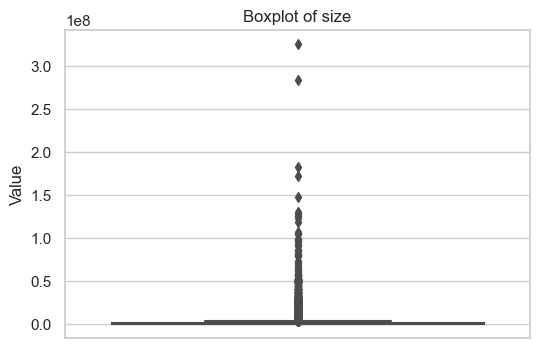

For feature: size
IQR = 7867077.200000001
Upper bound = 19673837.0
Lower bound = -11794471.8
Number of outliers: 403



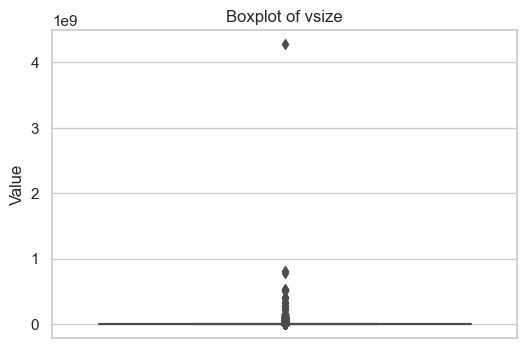

For feature: vsize
IQR = 11550720.0
Upper bound = 28897280.0
Lower bound = -17305600.0
Number of outliers: 274



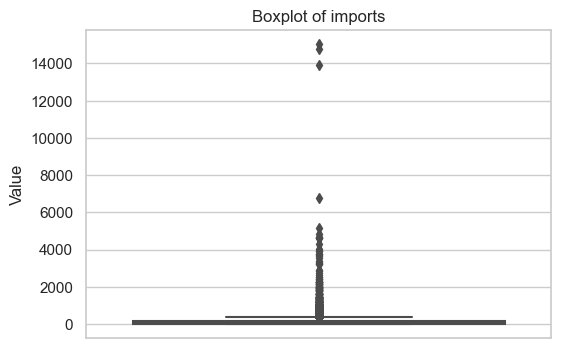

For feature: imports
IQR = 546.0
Upper bound = 1365.0
Lower bound = -819.0
Number of outliers: 112



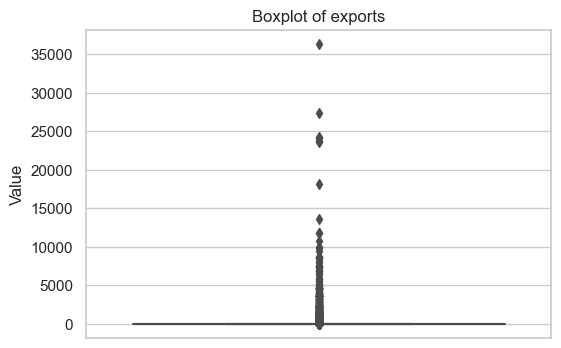

For feature: exports
IQR = 69.0
Upper bound = 172.5
Lower bound = -103.5
Number of outliers: 821



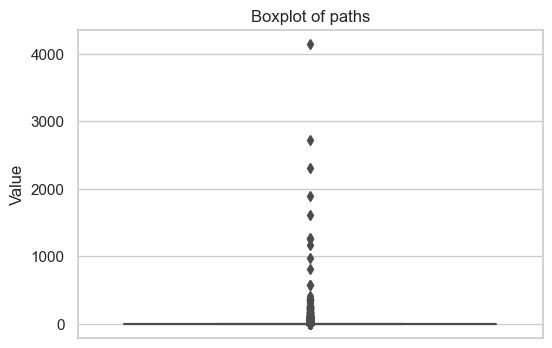

For feature: paths
IQR = 6.0
Upper bound = 15.0
Lower bound = -9.0
Number of outliers: 440



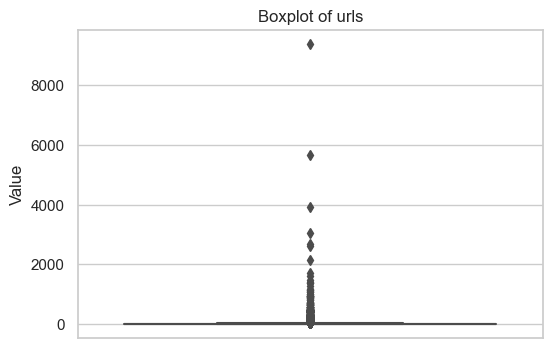

For feature: urls
IQR = 62.0
Upper bound = 155.0
Lower bound = -93.0
Number of outliers: 676



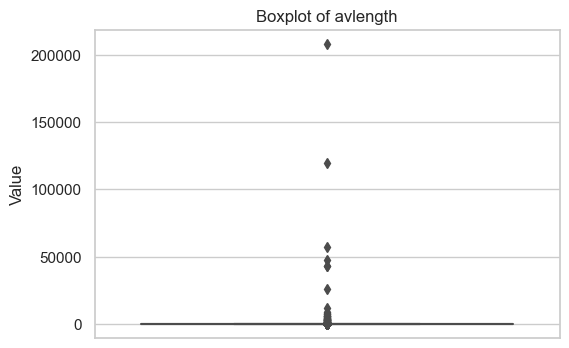

For feature: avlength
IQR = 113.823281023775
Upper bound = 290.23492153566247
Lower bound = -165.0582025594375
Number of outliers: 120



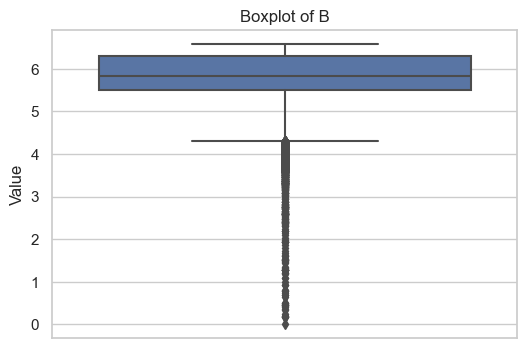

For feature: B
IQR = 2.290506384025
Upper bound = 10.0154467427125
Lower bound = 0.8534212066125
Number of outliers: 24



In [34]:
outliers_threshold = outliers_detection(X_train, 0.025, numeric_vars, True)

When comparing the distributions of features, it was noticed that the 'exports' feature has a slightly different distribution. Therefore, it has been decided not to remove the outliers from this feature.

##### Remove Ouliers:

In [35]:
def remove_outliers(data, bounds, col):
    outliers_removed = 0

    # Iterate over each feature and its bounds
    for feature, (lower_bound, upper_bound) in bounds.items():
        if feature in col and feature != 'exports':
            outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].index

            # Remove the outliers from the dataset
            data.drop(outliers, inplace=True)
            outliers_removed += len(outliers)

    print(f"Removed {outliers_removed} outliers from the data.")
    print("New DataFrame shape:", data.shape)

In [36]:
remove_outliers(X_train, outliers_threshold, X_train.columns)

Removed 1820 outliers from the data.
New DataFrame shape: (46180, 14)


---

### Normalize the data:

Data Normalization using mean-std Scaling:<br>
By subtracting the mean and dividing by the standard deviation of each feature, mean-std normalization ensures that the transformed features have zero mean and unit variance.

Normalization helps to eliminate the differences in scale between features, making them comparable on a similar scale. This is particularly important when working with algorithms that are sensitive to the scale of features.

Furthermore, mean-std normalization can mitigate the impact of outliers and extreme values in the data. Since the transformation is based on the mean and standard deviation, it is less influenced by outliers compared to some other scaling techniques.

In [37]:
def normalization(train_data, val_data, numeric_vars):
    new_train_data = train_data.copy()
    new_val_data = val_data.copy()

    for feature in numeric_vars:
        if feature in new_train_data.columns and feature in new_val_data.columns:
            train_mean = new_train_data[feature].mean()
            train_std = new_train_data[feature].std()

            new_train_data[feature] = (new_train_data[feature] - train_mean) / train_std
            new_val_data[feature] = (new_val_data[feature] - train_mean) / train_std

    return new_train_data, new_val_data

In [38]:
X_train, X_validation = normalization(X_train, X_validation, numeric_vars)

---

# Feature Selection ⚖️

##### Backward selection:

In [39]:
# def fit_predict(X: np.array, y: np.array):
#     # Changed to Random Forest regressor
#     rf = RandomForestRegressor() # our chosen model
#     rf.fit(X, y)
#     y_pred = rf.predict(X)
#     return y_pred

# def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
#     samples = X.shape[0]
#     features = X.shape[1]
#     y_pred = fit_predict(X, y)
#     rss = np.sum((y - y_pred) ** 2)
#     sigma_hat_squared = rss / (samples - features - 1)
#     return sigma_hat_squared

# def get_mallows_cp_score(X: np.array, y: np.array, sigma_hat_squared: float) -> float:
#     samples = X.shape[0]
#     features = X.shape[1]
#     y_pred = fit_predict(X, y)
#     mse = mean_squared_error(y, y_pred)
#     Cp = mse + 2 * (features + 1) / samples * sigma_hat_squared
#     return Cp

# def remove_feature(X: np.array, y: np.array, current_features: List[int], sigma_hat_squared: float) -> Dict:
#     # Updated to use Random Forest for prediction
#     rf = RandomForestRegressor()
#     rf.fit(X[:, current_features], y)
#     y_pred = rf.predict(X[:, current_features])
#     mse = mean_squared_error(y, y_pred) # Changed back to MSE
#     best_score = float('inf')
#     best_features_lst = []

#     for feature in current_features:
#         reduced_features = current_features.copy()
#         reduced_features.remove(feature)
#         X_reduced = X[:, reduced_features]

#         Cp = get_mallows_cp_score(X_reduced, y, sigma_hat_squared)
#         if Cp < best_score:
#             best_score = Cp
#             best_features_lst = reduced_features

#     return {'features': sorted(best_features_lst), 'score': best_score}

# def backward_selection(X: np.array, y: np.array) -> List[int]:
#     """
#     returns list of indexes for the selected features
#     X: 2d numpy array with original training data
#     y: numpy vector with targets of training data
#     returns: a sorted list containing the indexes of the selected features
#     """
#     # Calculate error on model with all features
#     sigma_hat_squared = get_sigma_hat_squared(X, y)
#     # set initial features to all features
#     current_features = list(range(X.shape[1]))
#     models_lst = []
#     #perform backward selection
#     while len(current_features) > 1:
#         # remove feature
#         model = remove_feature(X, y, current_features, sigma_hat_squared)
#         #update
#         current_features = model['features']
#         models_lst.append(model)
#     #Plotting
#     scores_lst = [x['score'] for x in models_lst]
#     plt.plot(range(1,len(scores_lst)+1),scores_lst)
#     plt.xlabel("number of features")
#     plt.ylabel("Mallows cp")
#     plt.title("Mallows Cp score VS number of features")
#     plt.show()

#     #Returning features of best model, based on mcp score
#     best_model = min(models_lst, key = lambda x: x['score'])
#     best_features = best_model['features']
#     return sorted(best_features)

# def get_features(df):

#     #Split data to X and y
#     X, y = df.values[:,:-1], df.values[:, -1]

#     #Running fw selection process
#     res = backward_selection(X,y)
#     print(f'number of selected features by backward: {len(res)}')
#     lst = []
#     for i in res:
#         lst.append(df.columns[i])
#     print('chosen features:\n',lst)
#     return res


# res = get_features(X_train)
# print(f'number of selected features by backward: {len(res)}')

# Modeling 📟

In [40]:
y_train = X_train['label'] #updating the labels after the process of the data
y_validation = X_validation['label'] #updating the labels after the process of the data

In [41]:
def model_evaluation(df, model):
    X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 1

    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    for train_idx, validation_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[validation_idx]
        y_train, y_val = y[train_idx], y[validation_idx]
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_val)
        fpr, tpr, threshold = roc_curve(y_val, pred[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(auc(fpr, tpr))
        plt.plot(fpr, tpr, lw=2, alpha=0.4, label=f'ROC fold {i} (AUC = {auc(fpr, tpr):.4f})')
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='c', label=f'Mean Train ROC (AUC = {mean_auc:.2f})', lw=2)

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()

    return mean_auc

The above function performs model evaluation using the ROC curve and calculates the mean AUC for a given classification model. It uses 5-fold cross-validation to obtain the ROC curve and AUC for each fold, and then plots them along with the mean ROC curve and mean AUC.

---

### KNN

In [42]:
def knn_grid_search(X, y, param_grid, cv=5):
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params

In [43]:
knn_param_grid = {
    'n_neighbors': list(range(3, 17, 2)), #using odd number allows the model not to split 50-50.
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}
knn_best_params = knn_grid_search(X_train, y_train, knn_param_grid)
print("Best parameters:", knn_best_params)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


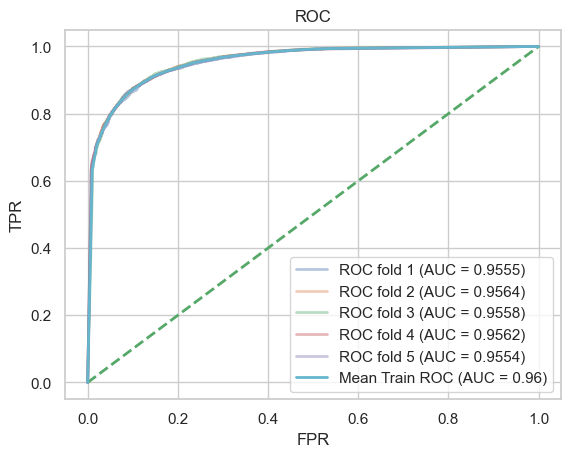

KNN Mean AUC-ROC: 0.9553932228891274


In [44]:
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')
knn_mean_auc = model_evaluation(X_train, knn_model)
print("KNN Mean AUC-ROC:", knn_mean_auc)

---

### Logistic Regression

In [45]:
def LR_grid_search(X, y, param_grid, scoring='roc_auc', cv=5):
    lr = LogisticRegression()
    grid_search = GridSearchCV(lr, param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params

In [46]:
LR_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

LR_best_params = LR_grid_search(X_train, y_train, LR_param_grid)
print("Best parameters:", LR_best_params)

Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


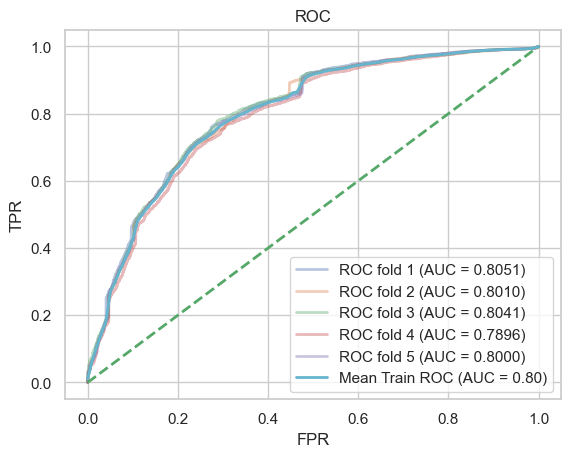

LR Mean AUC-ROC: 0.7997554886395971


In [47]:
Lr_model = LogisticRegression(**LR_best_params)
Lr_mean_auc = model_evaluation(X_train, Lr_model)
print("LR Mean AUC-ROC:", Lr_mean_auc)

---

##### Hyperparameter Tuning with RandomizedSearchCV

To find the best hyperparameters for our complex models, we used `RandomizedSearchCV` instead of grid search due to its faster runtime. Randomized search randomly samples a subset of hyperparameter combinations, reducing the search space and improving computational efficiency. While it may not explore all combinations like grid search, randomized search offers a good trade-off between runtime and performance. In our case, it helped us efficiently explore the hyperparameter space and find satisfactory results while reducing computational burden.

In [48]:
from sklearn.model_selection import RandomizedSearchCV

---

### Decision Tree

In [49]:
def DecisionTree_random_search(X, y, param_grid):
    DT_model = DecisionTreeClassifier()
    random_search = RandomizedSearchCV(estimator=DT_model, param_distributions=param_grid, n_iter=50, cv=3, random_state=42, n_jobs=-1, scoring='roc_auc')
    random_search.fit(X, y)

    best_params = random_search.best_params_
    best_score = random_search.best_score_

    return best_params

In [50]:
DT_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5,6,7,8,9,10,11,12,13,14,15],
    'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf': [1,2,3,4,5],
}

DT_best_params = DecisionTree_random_search(X_train, y_train, DT_param_grid)
print("Best parameters:", DT_best_params)

Best parameters: {'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 15, 'criterion': 'entropy'}


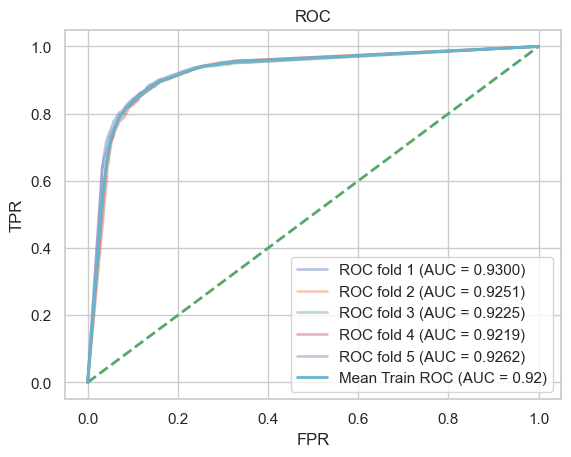

Decision Tree Mean AUC-ROC: 0.9249387961257367


In [51]:
DT_model = DecisionTreeClassifier(**DT_best_params)
DT_mean_auc = model_evaluation(X_train, DT_model)
print("Decision Tree Mean AUC-ROC:", DT_mean_auc)

We've compared the performance of the AdaBoost model with the Random Forest model. Due to higher accuracy results achieved by Random Forest, we decided to keep the Random Forest model for further analysis.

---

### Adaboost

In [52]:
def AB_grid_search(X, y, param_grid, cv=5):
    adaboost = AdaBoostClassifier()
    grid_search = GridSearchCV(adaboost , param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params

In [53]:
AB_param_grid = {
    'n_estimators': [50,70,90,110,130,150,200],
     'learning_rate': [0.5, 1.0]
     }

AB_best_params = AB_grid_search(X_train, y_train, AB_param_grid)
print("Best parameters:", AB_best_params)

Best parameters: {'learning_rate': 0.5, 'n_estimators': 50}


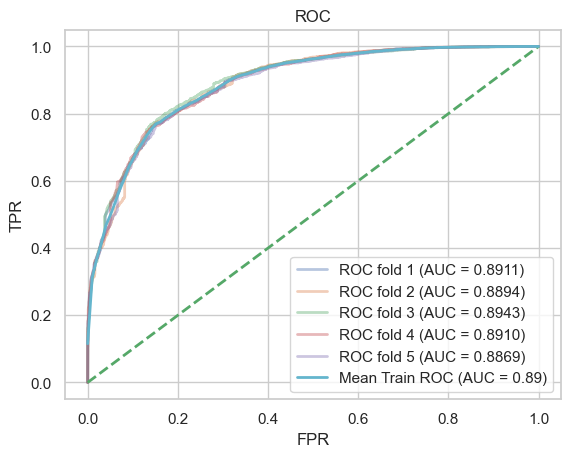

Adaboost Mean AUC-ROC: 0.8901629528327939


In [54]:
adaboost_model = AdaBoostClassifier(**AB_best_params)
AB_mean_auc = model_evaluation(X_train, adaboost_model)
print("Adaboost Mean AUC-ROC:", AB_mean_auc)

---

### Random Forest

In [55]:
def RF_random_search(X, y, param_grid):

    random_forest = RandomForestClassifier()
    random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid, n_iter=50, cv=3, random_state=42, n_jobs=-1, scoring='roc_auc')
    random_search.fit(X, y)


    best_params = random_search.best_params_
    best_score = random_search.best_score_

    return best_params

In [56]:
RF_param_grid = {
    'n_estimators': (50,70,90,110,130,150,170,190,210,230,250,270,290),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': (5,10,20,30,40,50,60,70,80,90,100,110),
    'min_samples_split': randint(1, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['sqrt', 'log2']
}
RF_best_params = RF_random_search(X_train, y_train, RF_param_grid)
print("Best parameters:", RF_best_params)

Best parameters: {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 250}


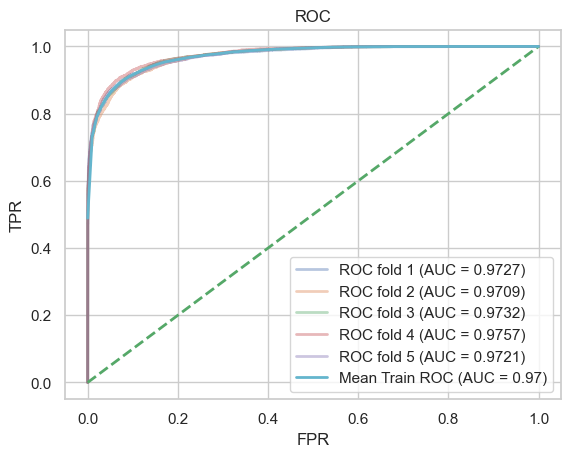

RF Mean AUC-ROC: 0.9723258021396768


In [57]:
RF_model = RandomForestClassifier(**RF_best_params)
Rf_mean_auc = model_evaluation(X_train, RF_model)
print("RF Mean AUC-ROC:", Rf_mean_auc)

### Random Forest - Fearure Importance

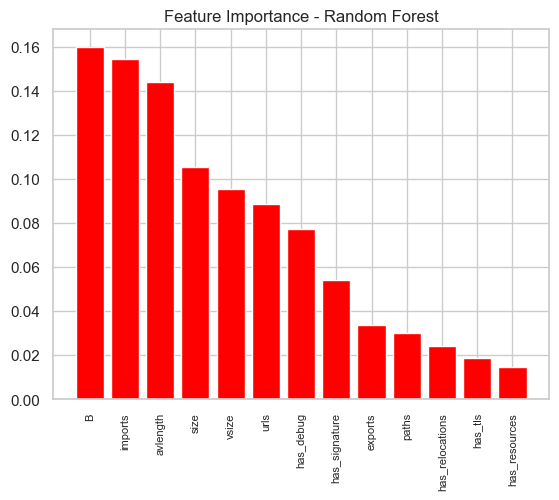

In [58]:
X_train_no_label = X_train.drop('label', axis=1)  # Remove the 'label' column from X_train
RFmodel = RF_model.fit(X_train_no_label, y_train)
importance = RFmodel.feature_importances_
sorted_indices = np.argsort(-importance)
feature_names = X_train_no_label.columns

plt.bar(range(X_train_no_label.shape[1]), importance[sorted_indices], color='red')
plt.xticks(range(X_train_no_label.shape[1]), [feature_names[i] for i in sorted_indices], rotation=90, fontsize=8)
plt.title("Feature Importance - Random Forest")
plt.show()

- **B**: Without additional context, it's difficult to provide specific insights for this feature.

- **imports**: The "imports" feature indicates the number of external functions imported by the file. Malicious files may have a different set or a larger number of imports compared to benign files, as they may require additional functionalities for their malicious activities.

- **avlength**: This feature refers to the average length of string within the file. Malicious files may exhibit distinctive patterns or deviations in their component lengths, potentially indicating the presence of obfuscated or malicious code.

- **size**: The "size" feature represents the overall size of the file. Malicious files can sometimes be larger due to the inclusion of additional malicious payloads or code, while benign files tend to have smaller sizes.

- **vsize**: This feature refers to the virtual size of the file, which relates to the amount of memory required to load the file. Similar to the "size" feature, malicious files may have larger virtual sizes compared to benign files, reflecting the presence of potentially harmful or complex code.

- **urls**: The presence or frequency of URLs within a file could be indicative of network activity or communication with malicious servers. Malicious files may exhibit a higher frequency of suspicious URLs.


- **has_debug** The presence of debug information in a file could indicate that it was compiled for debugging purposes. Malicious files might be less likely to have debug information, as it could make them easier to analyze and detect.

- **has_signature**: This feature likely indicates whether the file has a valid digital signature. Malicious files may be less likely to have signatures since they often attempt to avoid detection and tampering.


---

In [59]:
from scipy.stats import randint, uniform

### XGBoost

In [60]:
def XGBoost_random_search(X, y, param_grid):
    xgb_model = XGBClassifier(use_label_encoder=False)
    random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50, cv=3, random_state=42, n_jobs=-1, scoring='roc_auc')
    random_search.fit(X, y)

    best_params = random_search.best_params_
    best_score = random_search.best_score_

    return best_params

In [61]:
XGB_param_grid = {
     'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 5),
    'reg_lambda': uniform(0, 5)
}

XGB_best_params = XGBoost_random_search(X_train, y_train, XGB_param_grid)
print("Best parameters:", XGB_best_params)

Best parameters: {'gamma': 1.8727005942368125, 'learning_rate': 0.2952142919229748, 'max_depth': 5, 'n_estimators': 171, 'reg_alpha': 2.993292420985183, 'reg_lambda': 0.7800932022121826}


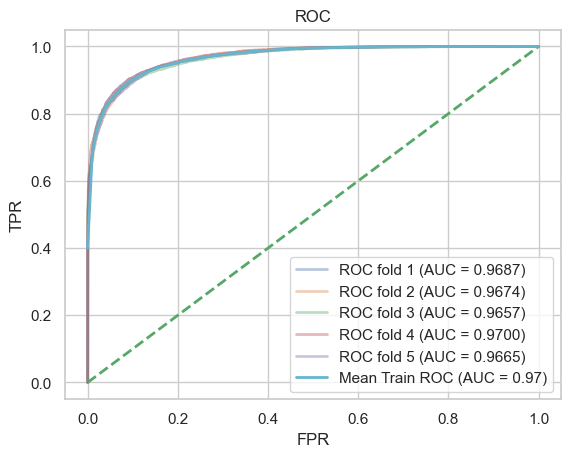

XGboost Mean AUC-ROC: 0.9668730093909885


In [62]:
xgb_model = XGBClassifier(**XGB_best_params, use_label_encoder=False)
xgb_mean_auc = model_evaluation(X_train, xgb_model)
print("XGboost Mean AUC-ROC:", xgb_mean_auc)

### XGboost - Fearure Importance

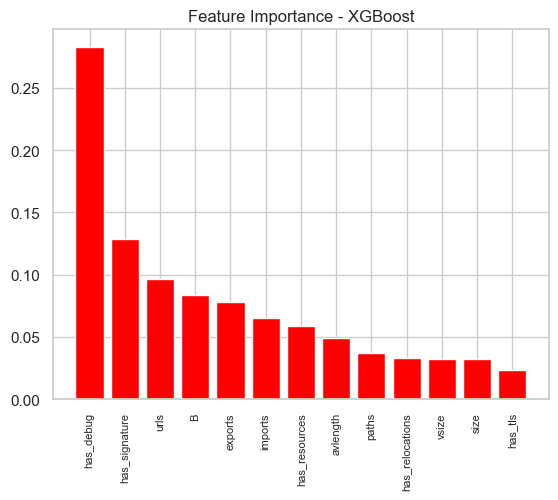

In [63]:
X_train_no_label = X_train.drop('label', axis=1)  # Remove the 'label' column from X_train
xgb_model.fit(X_train_no_label, y_train)
importance = xgb_model.feature_importances_
sorted_indices = np.argsort(-importance)
feature_names = X_train_no_label.columns

plt.bar(range(X_train_no_label.shape[1]), importance[sorted_indices], color='red')
plt.xticks(range(X_train_no_label.shape[1]), [feature_names[i] for i in sorted_indices], rotation=90, fontsize=8)
plt.title("Feature Importance - XGBoost")
plt.show()

---

### Models Evaluations

In [64]:
def model_scores(model, X_train, y_train, X_validation, y_validation):
    # Fit the model on the training data
    model.fit(X_train.drop('label', axis=1), y_train)

    # Calculate AUC scores for the training and validation data
    train_pred_proba = model.predict_proba(X_train.drop('label', axis=1))[:, 1]
    train_auc = round(roc_auc_score(y_train, train_pred_proba),4)

    validation_pred_proba = model.predict_proba(X_validation.drop('label', axis=1))[:, 1]
    validation_pred_labels = model.predict(X_validation.drop('label', axis=1))
    validation_auc = round(roc_auc_score(y_validation, validation_pred_proba),4)

    # Calculate the difference in AUC scores
    auc_diff = round(validation_auc - train_auc,4)

    # Print the model scores
    print(f'Model Train AUC score: {train_auc}')
    print(f'Model Validation AUC score: {validation_auc}')
    print(f'AUC Score Difference: {auc_diff}')

    return validation_auc, validation_pred_labels

In [65]:
knn_validation_auc, knn_validation_pred_labels = model_scores(knn_model, X_train, y_train, X_validation, y_validation)

Model Train AUC score: 1.0
Model Validation AUC score: 0.9562
AUC Score Difference: -0.0438


In [66]:
LR_validation_auc, LR_validation_pred_labels = model_scores(Lr_model, X_train, y_train, X_validation, y_validation)

Model Train AUC score: 0.8005
Model Validation AUC score: 0.7974
AUC Score Difference: -0.0031


In [67]:
DT_validation_auc, DT_validation_pred_labels = model_scores(DT_model, X_train, y_train, X_validation, y_validation)

Model Train AUC score: 0.984
Model Validation AUC score: 0.9267
AUC Score Difference: -0.0573


In [68]:
Adaboost_validation_auc, Adaboost_validation_pred_labels = model_scores(adaboost_model, X_train, y_train, X_validation, y_validation)

Model Train AUC score: 0.8923
Model Validation AUC score: 0.8936
AUC Score Difference: 0.0013


In [69]:
RF_validation_auc, RF_validation_pred_labels = model_scores(RF_model, X_train, y_train, X_validation, y_validation)

Model Train AUC score: 0.9972
Model Validation AUC score: 0.9739
AUC Score Difference: -0.0233


In [70]:
xgb_validation_auc, xgb_validation_pred_labels = model_scores(xgb_model, X_train, y_train, X_validation, y_validation)

Model Train AUC score: 0.9843
Model Validation AUC score: 0.9698
AUC Score Difference: -0.0145


### The Best Model 🥇

In [71]:
model_names = ['KNN Model', 'Logistic Regression Model', 'Decision Tree Model', 'AdaBoost Model', 'Random Forest Model', 'XGBoost Model']
val_auc = [knn_validation_auc, LR_validation_auc, DT_validation_auc, Adaboost_validation_auc, RF_validation_auc, xgb_validation_auc]

# Get the index of the model with the highest performance
best_model_index = val_auc.index(max(val_auc))

# Print the name and AUC score of the best model
best_model_name = model_names[best_model_index]
best_model_auc = val_auc[best_model_index]
print("Best Model:", best_model_name)
print("Val AUC:", best_model_auc)

Best Model: Random Forest Model
Val AUC: 0.9739


##### The model with the highest score on Validation set is **Random Forest**.

---

### Confusion Matrix 🎛️

In [72]:
def plt_confusin_mtx(y_validation, pred_labels):

    cm = confusion_matrix(y_validation, pred_labels)

    # Create a heatmap of the confusion matrix with percentage values
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])

    plt.show()

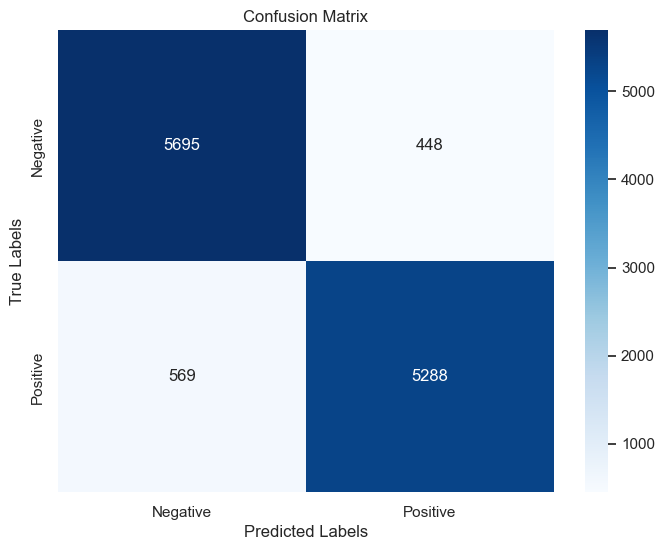

In [73]:
plt_confusin_mtx(y_validation, RF_validation_pred_labels)

It is observed that the model has a higher number of false negatives (FN) compared to false positives (FP). The FN value represents the cases where the model incorrectly predicts negative labels for positive instances. In the context of our domain, this indicates a higher vulnerability to missing or incorrectly classifying malignant executable files as benign.

This vulnerability to false negatives implies that there is a possibility of undetected malicious files, which can pose a potential security risk. It is important to note that addressing this issue would involve adjusting the model's threshold or decision boundary to be more conservative, prioritizing the correct classification of malignant files.

However, it is worth mentioning that the objective in this case is to maximize the AUC score, which evaluates the model's overall ability to distinguish between positive and negative instances. While the model may have a higher vulnerability to false negatives, optimizing the AUC score aims to strike a balance between sensitivity and specificity, considering both types of errors.

---

# Pipeline 🎞️

In [74]:
def pipeline (X_train, X_test):
    X_train = drop_features(X_train)
    X_test = drop_features(X_test)
    X_train, X_test = replace_null_binary(X_train, X_test, binary_vars, 51)
    X_train, X_test = replace_null_numeric(X_train, X_test, numeric_vars)
    remove_outliers(X_train, outliers_threshold, X_train.columns)
    X_train, X_test = normalization(X_train, X_test, numeric_vars)

    return X_train, X_test

In [75]:
def modeling_pipeline(X_train, X_test, y_train, y_test, param_grid):
    best_params = RF_random_search(X_train, y_train, param_grid)
    RF_model = RandomForestClassifier(**best_params)
    Rf_mean_auc = model_evaluation(X_train, RF_model)
    print("RF Mean AUC-ROC:", Rf_mean_auc)
    RF_validation_auc, RF_validation_pred_labels = model_scores(RF_model, X_train, y_train, X_test, y_test)
    plt_confusin_mtx(y_test, RF_validation_pred_labels)

    return RF_model

Removed 1820 outliers from the data.
New DataFrame shape: (46180, 14)


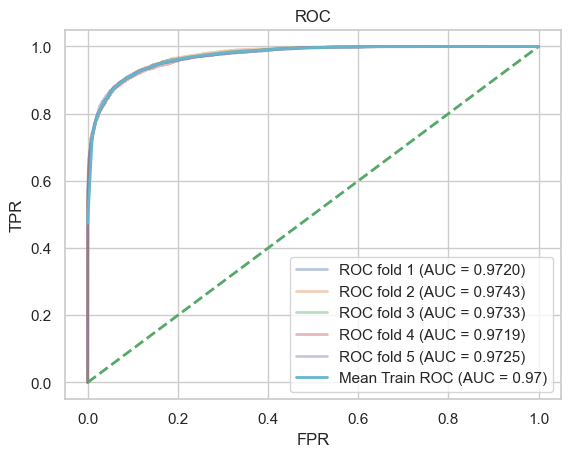

RF Mean AUC-ROC: 0.9721223556762432
Model Train AUC score: 0.9972
Model Validation AUC score: 0.9741
AUC Score Difference: -0.0231


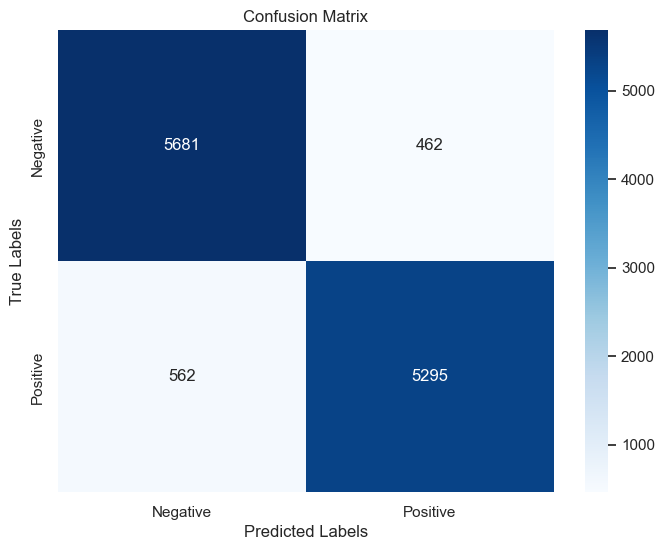

In [76]:
df = pd.read_csv("./train.csv")
df_label = df.iloc[:, -1]
X_train, X_validation, y_train, y_validation = train_test_split(df, df_label, train_size=0.8, random_state=42, shuffle=True)
X_train, X_validation = pipeline(X_train, X_validation)
y_train = X_train['label']
y_validation = X_validation['label']
param_grid = RF_param_grid
RF_model = modeling_pipeline(X_train, X_validation, y_train, y_validation, param_grid)

### Predictions 📝

In [77]:
test_data = pd.read_csv("test.csv")
X_train, X_validation, y_train, y_validation = train_test_split(df, df_label, train_size=0.8, random_state=42, shuffle=True)
X_train, X_test = pipeline(X_train, test_data)
test_pred = RF_model.predict_proba(X_test)
sha = pd.read_csv("test.csv")['sha256']
output=pd.DataFrame(data={"sha256":sha,"predict_proba":test_pred[:,1]}) 
output.to_csv(path_or_buf="results_36.csv",index=False,quoting=3,sep=',')

Removed 1820 outliers from the data.
New DataFrame shape: (46180, 14)


---